In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import s3fs
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pycountry

In [2]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [3]:
# Load the data
# csv file
url = "https://plasticpollution.s3.amazonaws.com/MLW_data_clean.csv"
MLW_data_df = pd.read_csv(url)
MLW_data_df

,BeachCountry,BeachName,BeachRegionalSea,BeachLength_m,BeachType,G1,G3,G4,G5,G7,...,G90,G91,G92,G93,G95,G96,G97,G98,G99,G100
0,Bulgaria,krapetz,Black Sea,5850,Sandy,NaN,NaN,1.0,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,Bulgaria,krapetz,Black Sea,5850,Sandy,NaN,12.0,1.0,NaN,10.0,...,NaN,NaN,1.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN
2,Bulgaria,krapetz,Black Sea,5850,Sandy,NaN,27.0,7.0,NaN,3.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0
3,Bulgaria,krapetz,Black Sea,5850,Sandy,NaN,15.0,60.0,NaN,18.0,...,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2.0,NaN
4,Italy,San Mauro Cilento (SA),Unknown,100,NaN,NaN,5.0,6.0,NaN,13.0,...,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,Italy,"Spiaggia di Marina di Montemarciano, Ancona (AN)",Mediterranean Sea,100,NaN,NaN,1.0,23.0,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8.0
3166,France,"La Lagune, 33260 La Teste de Buch, FRANCE",North-east Atlantic Ocean,548,NaN,NaN,0.0,1.0,NaN,0.0,...,NaN,5.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
3167,NaN,Bournemouth beach,North-east Atlantic Ocean,2302,Sandy,NaN,5.0,NaN,NaN,11.0,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
3168,Switzerland,cleanuptravels.com,NaN,22,Sandy,NaN,NaN,3.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
MLW_raw_df = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\MLW_Data.csv", encoding="iso-8859-1")
MLW_raw_df.EventDate = pd.to_datetime(MLW_raw_df.EventDate, format = "%Y%m%d").dt.year
# df.EventDate = pd.to_datetime(df.EventDate, format = "%Y%m%d")
# df.EventDate.unique()
# df.groupby("BeachCountrycode").sum()
# df.EventDate
MLW_raw_df

,CommunityName,BeachName,BeachCountrycode,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
0,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2016,Cleanup,NaN,...,2.0,4.0,NaN,3.0,NaN,NaN,3.0,NaN,1.0,NaN
1,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,1.0,NaN,2.0,NaN,NaN,NaN,7.0,3.0,NaN,NaN
2,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,2.0,1.0
3,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,5.0,NaN,2.0,NaN,NaN,NaN,5.0,26.0,NaN,NaN
4,Legambiente Onlus,San Mauro Cilento (SA),IT,Unknown,100,NaN,NaN,2018,Monitoring,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,Legambiente Onlus,"Spiaggia di Marina di Montemarciano, Ancona (AN)",IT,Mediterranean Sea,100,NaN,NaN,2016,Monitoring,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3409,Surfrider Foundation Europe,"La Lagune, 33260 La Teste de Buch, FRANCE",FR,North-east Atlantic Ocean,548,NaN,NaN,2018,Cleanup,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3410,Surfers Against Sewage,Bournemouth beach,UK,North-east Atlantic Ocean,2302,Urban,Sandy,2015,Cleanup,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
3411,ocean-R-evolution.com,cleanuptravels.com,CH,NaN,22,Rural,Sandy,2017,Cleanup,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [5]:
MLW_clean = MLW_raw_df.rename(columns={'BeachCountrycode': 'country_code'})
MLW_clean.head(75)

,CommunityName,BeachName,country_code,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
0,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2016,Cleanup,NaN,...,2.0,4.0,NaN,3.0,NaN,NaN,3.0,NaN,1.0,NaN
1,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,1.0,NaN,2.0,NaN,NaN,NaN,7.0,3.0,NaN,NaN
2,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,2.0,1.0
3,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,NaN,...,5.0,NaN,2.0,NaN,NaN,NaN,5.0,26.0,NaN,NaN
4,Legambiente Onlus,San Mauro Cilento (SA),IT,Unknown,100,NaN,NaN,2018,Monitoring,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Swiss Litter Report,katzenbach_zuerich_sanesim,CH,NaN,99,Rural,Other (mixed),2017,Cleanup,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Swiss Litter Report,katzenbach_zuerich_sanesim,CH,NaN,99,Rural,Other (mixed),2017,Cleanup,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,Swiss Litter Report,katzenbach_zuerich_sanesim,CH,NaN,99,Rural,Other (mixed),2017,Cleanup,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
73,Surfrider Foundation Europe,"41 Zeedijk, 8380 zeebrugge, Belgique",BE,North-east Atlantic Ocean,69,NaN,NaN,2015,Cleanup,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN


In [6]:
# Replace NaN values with empty string on country_code column
MLW_clean = MLW_clean.replace(np.nan, '', regex=True)
# country_code_df[['country_code']].fillna('')
MLW_clean

,CommunityName,BeachName,country_code,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
0,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2016,Cleanup,,...,2.0,4.0,,3.0,,,3.0,,1.0,
1,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,1.0,,2.0,,,,7.0,3.0,,
2,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,,,5.0,,,,2.0,,2.0,1.0
3,gBqsPxAZ,krapetz,BG,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,5.0,,2.0,,,,5.0,26.0,,
4,Legambiente Onlus,San Mauro Cilento (SA),IT,Unknown,100,,,2018,Monitoring,,...,,,,,,,3.0,,2.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,Legambiente Onlus,"Spiaggia di Marina di Montemarciano, Ancona (AN)",IT,Mediterranean Sea,100,,,2016,Monitoring,,...,1.0,,,,,,,1.0,,
3409,Surfrider Foundation Europe,"La Lagune, 33260 La Teste de Buch, FRANCE",FR,North-east Atlantic Ocean,548,,,2018,Cleanup,,...,,,,,,,1.0,,,
3410,Surfers Against Sewage,Bournemouth beach,UK,North-east Atlantic Ocean,2302,Urban,Sandy,2015,Cleanup,,...,,,,,,,8.0,,,
3411,ocean-R-evolution.com,cleanuptravels.com,CH,,22,Rural,Sandy,2017,Cleanup,,...,,,,,,,1.0,,,


In [7]:
country_code_df = pd.DataFrame(MLW_clean.country_code.unique())
country_code_df.columns = ['country_code']
country_code_df

,country_code
0,BG
1,IT
2,
3,CH
4,GR
5,FR
6,Int
7,GE
8,ES
9,DK


In [8]:
country_code_df

list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
list_alpha_3 = [i.alpha_3 for i in list(pycountry.countries)] 

def country_flag(df):
    if (len(df['country_code'])==2 and df['country_code'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['country_code']).name
    elif (len(df['country_code'])==3 and df['country_code'] in list_alpha_3):
        return pycountry.countries.get(alpha_3=df['country_code']).name
    else:
        return 'xxxx'

country_code_df['country_name']=country_code_df.apply(country_flag, axis = 1)
country_code_df

,country_code,country_name
0,BG,Bulgaria
1,IT,Italy
2,,xxxx
3,CH,Switzerland
4,GR,Greece
5,FR,France
6,Int,xxxx
7,GE,Georgia
8,ES,Spain
9,DK,Denmark


In [9]:
MLW_clean['country_code'] = MLW_clean['country_code'].map(country_code_df.set_index('country_code')['country_name'])
# MLW_clean.rename(columns={'country_code' : 'Country'}, inplace=True)
MLW_clean

,CommunityName,BeachName,country_code,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
0,gBqsPxAZ,krapetz,Bulgaria,Black Sea,5850,Rural,Sandy,2016,Cleanup,,...,2.0,4.0,,3.0,,,3.0,,1.0,
1,gBqsPxAZ,krapetz,Bulgaria,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,1.0,,2.0,,,,7.0,3.0,,
2,gBqsPxAZ,krapetz,Bulgaria,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,,,5.0,,,,2.0,,2.0,1.0
3,gBqsPxAZ,krapetz,Bulgaria,Black Sea,5850,Rural,Sandy,2015,Cleanup,,...,5.0,,2.0,,,,5.0,26.0,,
4,Legambiente Onlus,San Mauro Cilento (SA),Italy,Unknown,100,,,2018,Monitoring,,...,,,,,,,3.0,,2.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,Legambiente Onlus,"Spiaggia di Marina di Montemarciano, Ancona (AN)",Italy,Mediterranean Sea,100,,,2016,Monitoring,,...,1.0,,,,,,,1.0,,
3409,Surfrider Foundation Europe,"La Lagune, 33260 La Teste de Buch, FRANCE",France,North-east Atlantic Ocean,548,,,2018,Cleanup,,...,,,,,,,1.0,,,
3410,Surfers Against Sewage,Bournemouth beach,xxxx,North-east Atlantic Ocean,2302,Urban,Sandy,2015,Cleanup,,...,,,,,,,8.0,,,
3411,ocean-R-evolution.com,cleanuptravels.com,Switzerland,,22,Rural,Sandy,2017,Cleanup,,...,,,,,,,1.0,,,


In [10]:
MLW_clean_df = MLW_clean.loc[MLW_clean['EventDate'].isin([2017, 2018, 2019, 2020, 2021])]
MLW_clean_df

,CommunityName,BeachName,country_code,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
4,Legambiente Onlus,San Mauro Cilento (SA),Italy,Unknown,100,,,2018,Monitoring,,...,,,,,,,3.0,,2.0,
6,Surfrider Foundation Europe,"7 Place Salvador Allende, 94000 Cr?teil, France",xxxx,Unknown,750,,,2019,Cleanup,,...,,,,,,,12.0,,,0.0
7,Swiss Litter Report,zürichsee_wollishofen_langendorfm,Switzerland,,50,Urban,Rocky,2017,Cleanup,,...,,,,,,,4.0,,,
13,Swiss Litter Report,sorne_birse_WWFJura,Switzerland,,16,Urban,Pebbels,2017,Cleanup,,...,,,,,,,13.0,,,
14,Swiss Litter Report,sorne_birse_WWFJura,Switzerland,,16,Urban,Pebbels,2017,Cleanup,,...,,,,,,,15.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2017,Monitoring,,...,,,,,,,,,,
3405,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2018,Monitoring,,...,,,,,,,,,,
3406,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2017,Monitoring,,...,,,,,,,,,,
3409,Surfrider Foundation Europe,"La Lagune, 33260 La Teste de Buch, FRANCE",France,North-east Atlantic Ocean,548,,,2018,Cleanup,,...,,,,,,,1.0,,,


In [11]:
MLW_clean_df = MLW_clean_df.rename(columns={'country_code': 'Country'})
MLW_clean_df

,CommunityName,BeachName,Country,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
4,Legambiente Onlus,San Mauro Cilento (SA),Italy,Unknown,100,,,2018,Monitoring,,...,,,,,,,3.0,,2.0,
6,Surfrider Foundation Europe,"7 Place Salvador Allende, 94000 Cr?teil, France",xxxx,Unknown,750,,,2019,Cleanup,,...,,,,,,,12.0,,,0.0
7,Swiss Litter Report,zürichsee_wollishofen_langendorfm,Switzerland,,50,Urban,Rocky,2017,Cleanup,,...,,,,,,,4.0,,,
13,Swiss Litter Report,sorne_birse_WWFJura,Switzerland,,16,Urban,Pebbels,2017,Cleanup,,...,,,,,,,13.0,,,
14,Swiss Litter Report,sorne_birse_WWFJura,Switzerland,,16,Urban,Pebbels,2017,Cleanup,,...,,,,,,,15.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2017,Monitoring,,...,,,,,,,,,,
3405,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2018,Monitoring,,...,,,,,,,,,,
3406,Monitoraggio Strategia Marina  Ministero dell...,Cesenatico,Italy,Mediterranean Sea,99,,,2017,Monitoring,,...,,,,,,,,,,
3409,Surfrider Foundation Europe,"La Lagune, 33260 La Teste de Buch, FRANCE",France,North-east Atlantic Ocean,548,,,2018,Cleanup,,...,,,,,,,1.0,,,


In [12]:
MLW_clean_df = MLW_clean_df.drop(columns=['CommunityName', 'BeachName', 'BeachRegionalSea', 'BeachLocation', 'BeachType', 'EventType', 'NatRef', 'lon_x1', 'lat_y2'])
MLW_clean_df

,Country,BeachLength_m,EventDate,lat_y1,lon_x2,G1,G3,G4,G5,G7,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
4,Italy,100,2018,0.000361,0.000135,,5.0,6.0,,13.0,...,,,,,,,3.0,,2.0,
6,xxxx,750,2019,48.779215,2.452715,,25.0,,,2.0,...,,,,,,,12.0,,,0.0
7,Switzerland,50,2017,47.345890,8.536055,,,,,,...,,,,,,,4.0,,,
13,Switzerland,16,2017,47.370987,7.360816,,1.0,,,,...,,,,,,,13.0,,,
14,Switzerland,16,2017,47.370987,7.360816,,1.0,2.0,,1.0,...,,,,,,,15.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,Italy,99,2017,44.213380,12.392820,5.0,60.0,60.0,60.0,5.0,...,,,,,,,,,,
3405,Italy,99,2018,44.213380,12.392820,5.0,60.0,60.0,60.0,5.0,...,,,,,,,,,,
3406,Italy,99,2017,44.213380,12.392820,5.0,60.0,60.0,60.0,5.0,...,,,,,,,,,,
3409,France,548,2018,44.548088,-1.250983,,0.0,1.0,,0.0,...,,,,,,,1.0,,,


In [13]:
MLW_clean_df = MLW_clean_df.drop(columns=['lat_y1', 'lon_x2'])
MLW_clean_df

,Country,BeachLength_m,EventDate,G1,G3,G4,G5,G7,G8,G9,...,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213
4,Italy,100,2018,,5.0,6.0,,13.0,19.0,13.0,...,,,,,,,3.0,,2.0,
6,xxxx,750,2019,,25.0,,,2.0,1.0,,...,,,,,,,12.0,,,0.0
7,Switzerland,50,2017,,,,,,,,...,,,,,,,4.0,,,
13,Switzerland,16,2017,,1.0,,,,,,...,,,,,,,13.0,,,
14,Switzerland,16,2017,,1.0,2.0,,1.0,,,...,,,,,,,15.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,Italy,99,2017,5.0,60.0,60.0,60.0,5.0,5.0,1.0,...,,,,,,,,,,
3405,Italy,99,2018,5.0,60.0,60.0,60.0,5.0,5.0,1.0,...,,,,,,,,,,
3406,Italy,99,2017,5.0,60.0,60.0,60.0,5.0,5.0,1.0,...,,,,,,,,,,
3409,France,548,2018,,0.0,1.0,,0.0,2.0,,...,,,,,,,1.0,,,


In [14]:
# Load the data 
# CSV File from S3 MLW_meta
url = "https://plasticpollution.s3.amazonaws.com/MLW_meta_clean.csv"
MLW_meta_df = pd.read_csv(url)
MLW_meta_df

,generalcode,category,generalname
0,G1,Plastic,"4/6-pack yokes, six-pack rings"
1,G3,Plastic,Shopping Bags incl. pieces
2,G4,Plastic,"Small plastic bags, e.g. freezer bags incl. pi..."
3,G5,Plastic,Plastic bags collective role; what remains fro...
4,G7,Plastic,Drink bottles <=0.5l
...,...,...,...
159,G210,Glass/ceramics,Other glass items
160,G211,unidentified,"Other medical items (swabs, bandaging, adhesiv..."
161,G213,Chemicals,Paraffin/Wax
162,G301,Cloth/textile,Disposable mask


In [15]:
# Load the data 
# CSV File from S3 Mismanagement
url = "https://plasticpollution.s3.amazonaws.com/Plastic_waste_mismanagement_clean.csv"
mismanagement_df = pd.read_csv(url)
mismanagement_df

,Country,Code,Year,PlasticWaste(metric tons)
0,Africa,NaN,2019,13690104
1,Albania,ALB,2019,69833
2,Algeria,DZA,2019,764578
3,Angola,AGO,2019,236946
4,Antigua and Barbuda,ATG,2019,627
...,...,...,...,...
166,Vietnam,VNM,2019,1112790
167,Western Sahara,ESH,2019,4114
168,World,OWID_WRL,2019,61773700
169,Yemen,YEM,2019,291737


In [16]:
# Rename columns
mismanagement_df = mismanagement_df.rename(columns={"PlasticWaste(metric tons)": "Metric_Tons"})
mismanagement_df

,Country,Code,Year,Metric_Tons
0,Africa,NaN,2019,13690104
1,Albania,ALB,2019,69833
2,Algeria,DZA,2019,764578
3,Angola,AGO,2019,236946
4,Antigua and Barbuda,ATG,2019,627
...,...,...,...,...
166,Vietnam,VNM,2019,1112790
167,Western Sahara,ESH,2019,4114
168,World,OWID_WRL,2019,61773700
169,Yemen,YEM,2019,291737


In [17]:
# Load the data 
# CSV File from S3
url = 'https://plasticpollution.s3.amazonaws.com/pbt_clean.csv'
pbt_df = pd.read_csv(url)
pbt_df

,COUNTRY NAME,YEAR,VALUE
0,Albania,2017,16481.0
1,Albania,2018,18094.0
2,Albania,2019,18500.0
3,Albania,2020,20157.0
4,Albania,2021,19828.0
...,...,...,...
695,Yemen,2017,30194.0
696,Yemen,2018,34205.0
697,Yemen,2019,35625.0
698,Yemen,2020,36032.0


In [54]:
# Rename columns 
pbt_df = pbt_df.rename(columns={'COUNTRY NAME' : 'Country', 'YEAR' : 'Year', 'VALUE' : 'Metric_Tons'})
pbt_df.Year.unique()
# pbt_df

array([2017, 2018, 2019, 2020, 2021], dtype=int64)

In [19]:
pbt_df.describe()

,Year,Metric_Tons
count,700.000000,7.000000e+02
mean,2019.000000,8.147552e+04
std,1.415225,2.819309e+05
min,2017.000000,9.000000e+00
25%,2018.000000,5.930000e+02
50%,2019.000000,6.323500e+03
75%,2020.000000,3.187925e+04
max,2021.000000,2.777198e+06


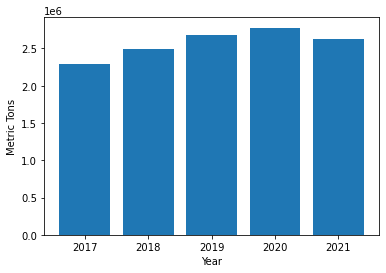

In [20]:
#Bar Graph for PBT
plt.bar(pbt_df.Year, pbt_df.Metric_Tons)
plt.xlabel('Year')
plt.ylabel('Metric Tons')
plt.show()

In [22]:
pwaste_df = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\2021_2016_2010.csv")
pwaste_df

,country,mpw_oceans_2021,mpw_2021,pWaste2016,pWastePercap2016,pWaste2010
0,Philippines,356371.0,4025300.0,1543668.0,14.89,2565766.0
1,India,126513.0,12994100.0,26327933.0,19.88,4493080.0
2,Malaysia,73098.0,814454.0,2058501.0,67.09,2031675.0
3,China,70707.0,12272200.0,21599465.0,15.67,59079741.0
4,Indonesia,56333.0,824234.0,9128000.0,34.90,5045714.0
...,...,...,...,...,...,...
215,San Marino,NaN,NaN,962.0,28.71,NaN
216,Gibraltar,NaN,NaN,2975.0,88.20,3053.0
217,British Virgin Islands,NaN,NaN,2643.0,90.05,2504.0
218,Tuvalu,NaN,NaN,658.0,58.64,554.0


In [23]:
pwaste_df.sort_values('mpw_oceans_2021', ascending=False)

,country,mpw_oceans_2021,mpw_2021,pWaste2016,pWastePercap2016,pWaste2010
0,Philippines,356371.0,4025300.0,1543668.0,14.89,2565766.0
1,India,126513.0,12994100.0,26327933.0,19.88,4493080.0
2,Malaysia,73098.0,814454.0,2058501.0,67.09,2031675.0
3,China,70707.0,12272200.0,21599465.0,15.67,59079741.0
4,Indonesia,56333.0,824234.0,9128000.0,34.90,5045714.0
...,...,...,...,...,...,...
215,San Marino,NaN,NaN,962.0,28.71,NaN
216,Gibraltar,NaN,NaN,2975.0,88.20,3053.0
217,British Virgin Islands,NaN,NaN,2643.0,90.05,2504.0
218,Tuvalu,NaN,NaN,658.0,58.64,554.0


In [24]:
pwaste_df.describe()

,mpw_oceans_2021,mpw_2021,pWaste2016,pWastePercap2016,pWaste2010
count,162.000000,1.630000e+02,2.110000e+02,205.000000,1.660000e+02
mean,5957.586420,3.789798e+05,1.057606e+06,45.900244,1.645469e+06
std,31043.215545,1.469056e+06,3.548861e+06,43.044921,5.691942e+06
min,0.000000,3.000000e+00,5.070000e+02,1.490000,5.270000e+02
25%,7.500000,1.716500e+03,2.930350e+04,15.670000,3.257275e+04
50%,229.500000,2.169300e+04,1.744570e+05,32.610000,3.049295e+05
75%,1410.250000,2.154820e+05,6.261310e+05,60.950000,1.130680e+06
max,356371.000000,1.299410e+07,3.402075e+07,308.250000,5.907974e+07


In [62]:
GDP_population_df = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\2010_per-capita-plastic-waste-vs-gdp-per-capita.csv")
GDP_population_df

,Entity,Code,Year,Per capita plastic waste (kg/person/day),"GDP per capita, PPP (constant 2017 international $)",Population (historical estimates),Continent
0,Abkhazia,OWID_ABK,2015,NaN,NaN,NaN,Asia
1,Afghanistan,AFG,2002,NaN,1189.784668,22600774.0,NaN
2,Afghanistan,AFG,2003,NaN,1235.810059,23680871.0,NaN
3,Afghanistan,AFG,2004,NaN,1200.277954,24726689.0,NaN
4,Afghanistan,AFG,2005,NaN,1286.793701,25654274.0,NaN
...,...,...,...,...,...,...,...
56119,Zimbabwe,ZWE,1987,NaN,NaN,9527202.0,NaN
56120,Zimbabwe,ZWE,1988,NaN,NaN,9849129.0,NaN
56121,Zimbabwe,ZWE,1989,NaN,NaN,10153852.0,NaN
56122,Zimbabwe,ZWE,2021,NaN,NaN,15092171.0,NaN


In [26]:
GDP_population_df = GDP_population_df.drop(columns=['Per capita plastic waste (kg/person/day)', 'Code', 'Continent'], axis=1)
GDP_population_df

,Entity,Year,"GDP per capita, PPP (constant 2017 international $)",Population (historical estimates)
0,Abkhazia,2015,NaN,NaN
1,Afghanistan,2002,1189.784668,22600774.0
2,Afghanistan,2003,1235.810059,23680871.0
3,Afghanistan,2004,1200.277954,24726689.0
4,Afghanistan,2005,1286.793701,25654274.0
...,...,...,...,...
56119,Zimbabwe,1987,NaN,9527202.0
56120,Zimbabwe,1988,NaN,9849129.0
56121,Zimbabwe,1989,NaN,10153852.0
56122,Zimbabwe,2021,NaN,15092171.0


In [27]:
GDP_population_df.Year.unique()

array([  2015,   2002,   2003,   2004,   2005,   2006,   2007,   2008,
         2009,   2010,   2011,   2012,   2013,   2014,   2016,   2017,
         2018,   2019,   2020, -10000,  -9000,  -8000,  -7000,  -6000,
        -5000,  -4000,  -3000,  -2000,  -1000,      0,    100,    200,
          300,    400,    500,    600,    700,    800,    900,   1000,
         1100,   1200,   1300,   1400,   1500,   1600,   1700,   1710,
         1720,   1730,   1740,   1750,   1760,   1770,   1780,   1790,
         1800,   1801,   1802,   1803,   1804,   1805,   1806,   1807,
         1808,   1809,   1810,   1811,   1812,   1813,   1814,   1815,
         1816,   1817,   1818,   1819,   1820,   1821,   1822,   1823,
         1824,   1825,   1826,   1827,   1828,   1829,   1830,   1831,
         1832,   1833,   1834,   1835,   1836,   1837,   1838,   1839,
         1840,   1841,   1842,   1843,   1844,   1845,   1846,   1847,
         1848,   1849,   1850,   1851,   1852,   1853,   1854,   1855,
      

In [63]:
GDP_population_df = GDP_population_df.loc[GDP_population_df['Year'].isin([2016, 2017, 2018, 2019, 2020])]
GDP_population_df

,Entity,Code,Year,Per capita plastic waste (kg/person/day),"GDP per capita, PPP (constant 2017 international $)",Population (historical estimates),Continent
15,Afghanistan,AFG,2016,NaN,2057.067871,35383028.0,NaN
16,Afghanistan,AFG,2017,NaN,2058.400146,36296111.0,NaN
17,Afghanistan,AFG,2018,NaN,2033.804443,37171922.0,NaN
18,Afghanistan,AFG,2019,NaN,2065.036133,38041757.0,NaN
19,Afghanistan,AFG,2020,NaN,1970.560181,38928341.0,NaN
...,...,...,...,...,...,...,...
55890,Zimbabwe,ZWE,2016,NaN,3678.217041,14030338.0,NaN
55891,Zimbabwe,ZWE,2017,NaN,3795.642334,14236599.0,NaN
55892,Zimbabwe,ZWE,2018,NaN,3923.030518,14438812.0,NaN
55893,Zimbabwe,ZWE,2019,NaN,3630.033936,14645473.0,NaN


In [29]:
GDP_population_df = GDP_population_df.rename(columns={"GDP per capita, PPP (constant 2017 international $)": "GDP_per_capita", "Population (historical estimates)": "Population", "Entity" : "Country"})
GDP_population_df

,Country,Year,GDP_per_capita,Population
16,Afghanistan,2017,2058.400146,3.629611e+07
17,Afghanistan,2018,2033.804443,3.717192e+07
18,Afghanistan,2019,2065.036133,3.804176e+07
19,Afghanistan,2020,1970.560181,3.892834e+07
514,Africa,2017,NaN,1.244222e+09
...,...,...,...,...
55634,Zambia,2020,3277.816406,1.838396e+07
55891,Zimbabwe,2017,3795.642334,1.423660e+07
55892,Zimbabwe,2018,3923.030518,1.443881e+07
55893,Zimbabwe,2019,3630.033936,1.464547e+07


In [30]:
GDP_population_df.describe()

,Year,GDP_per_capita,Population
count,1026.000000,829.000000,9.700000e+02
mean,2018.497076,21264.906505,9.490988e+07
std,1.119447,21736.983723,5.917959e+08
min,2017.000000,731.063232,7.980000e+02
25%,2017.000000,5109.805176,4.256008e+05
50%,2018.000000,13636.361328,5.754817e+06
75%,2019.000000,30846.583984,2.516971e+07
max,2020.000000,132373.546875,7.794799e+09


In [31]:
GDP_population_df['GDP_per_capita'].nlargest(n=10)

28839    132373.546875
28840    127272.546875
28838    126144.101562
28581    116518.273438
28580    115049.929688
28579    114985.843750
28582    112557.312500
44477     98411.585938
44476     98222.843750
44475     95350.437500
Name: GDP_per_capita, dtype: float64

In [32]:
GDP_population_df.sort_values('GDP_per_capita', ascending=True)

,Country,Year,GDP_per_capita,Population
8097,Burundi,2020,731.063232,11890781.0
8096,Burundi,2019,751.664124,11530577.0
8095,Burundi,2018,761.524109,11175379.0
8094,Burundi,2017,773.572876,10827010.0
9435,Central African Republic,2017,912.803040,4596023.0
...,...,...,...,...
55080,Western Sahara,2020,NaN,597330.0
55596,Yemen,2017,NaN,27834811.0
55597,Yemen,2018,NaN,28498683.0
55598,Yemen,2019,NaN,29161922.0


In [33]:
GDP_population_df.sort_values('Population', ascending=False).head(60)

,Country,Year,GDP_per_capita,Population
55112,World,2020,16185.165039,7.794799e+09
55111,World,2019,16897.171875,7.713468e+09
55110,World,2018,16607.765625,7.631091e+09
55109,World,2017,16211.049805,7.548183e+09
2932,Asia,2020,NaN,4.639847e+09
2931,Asia,2019,NaN,4.600173e+09
2930,Asia,2018,NaN,4.559478e+09
2929,Asia,2017,NaN,4.517860e+09
10287,China,2020,16315.815430,1.439324e+09
10286,China,2019,15977.645508,1.433784e+09


In [34]:
list_countries_df = GDP_population_df.loc[GDP_population_df['Country'].isin(['Saint Kitts and Nevis', 'United Arab Emirates', 'Indonesia', 'Seychelles', 'Nigeria', 'United States of America', 'Australia', 'Russia', 'Russian Federation', 'Germany', 'United States', 'China', 'Philippines', 'Brazil', 'Argentina'])]
# list_countries.values.tolist()
list_countries_df

,Country,Year,GDP_per_capita,Population
2078,Argentina,2017,23597.117188,4.393714e+07
2079,Argentina,2018,22747.242188,4.436115e+07
2080,Argentina,2019,22066.101562,4.478068e+07
2081,Argentina,2020,19690.662109,4.519578e+07
2961,Australia,2017,48398.550781,2.458462e+07
2962,Australia,2018,49029.105469,2.489815e+07
2963,Australia,2019,49309.113281,2.520320e+07
2964,Australia,2020,48678.683594,2.549988e+07
6985,Brazil,2017,14524.613281,2.078338e+08
6986,Brazil,2018,14668.255859,2.094693e+08


In [35]:
GDP_population_uniques = pd.DataFrame(GDP_population_df.Country.unique())
GDP_population_uniques

,0
0,Afghanistan
1,Africa
2,Albania
3,Algeria
4,American Samoa
...,...
253,Western Sahara
254,World
255,Yemen
256,Zambia


In [36]:
list_countries_df

,Country,Year,GDP_per_capita,Population
2078,Argentina,2017,23597.117188,4.393714e+07
2079,Argentina,2018,22747.242188,4.436115e+07
2080,Argentina,2019,22066.101562,4.478068e+07
2081,Argentina,2020,19690.662109,4.519578e+07
2961,Australia,2017,48398.550781,2.458462e+07
2962,Australia,2018,49029.105469,2.489815e+07
2963,Australia,2019,49309.113281,2.520320e+07
2964,Australia,2020,48678.683594,2.549988e+07
6985,Brazil,2017,14524.613281,2.078338e+08
6986,Brazil,2018,14668.255859,2.094693e+08


In [37]:
list_countries_df.describe()

,Year,GDP_per_capita,Population
count,52.000000,52.000000,5.200000e+01
mean,2018.500000,29713.075374,2.193995e+08
std,1.128942,20137.313593,3.679892e+08
min,2017.000000,4916.721191,5.203600e+04
25%,2017.750000,14198.644775,2.481977e+07
50%,2018.500000,25177.078125,1.073840e+08
75%,2019.250000,49099.107422,2.114270e+08
max,2020.000000,68263.671875,1.439324e+09


In [38]:
GDP_population_uniques.values.tolist()

[['Afghanistan'],
 ['Africa'],
 ['Albania'],
 ['Algeria'],
 ['American Samoa'],
 ['Andorra'],
 ['Angola'],
 ['Anguilla'],
 ['Antigua and Barbuda'],
 ['Argentina'],
 ['Armenia'],
 ['Aruba'],
 ['Asia'],
 ['Australia'],
 ['Austria'],
 ['Azerbaijan'],
 ['Bahamas'],
 ['Bahrain'],
 ['Bangladesh'],
 ['Barbados'],
 ['Belarus'],
 ['Belgium'],
 ['Belize'],
 ['Benin'],
 ['Bermuda'],
 ['Bhutan'],
 ['Bolivia'],
 ['Bonaire Sint Eustatius and Saba'],
 ['Bosnia and Herzegovina'],
 ['Botswana'],
 ['Brazil'],
 ['British Virgin Islands'],
 ['Brunei'],
 ['Bulgaria'],
 ['Burkina Faso'],
 ['Burundi'],
 ['Cambodia'],
 ['Cameroon'],
 ['Canada'],
 ['Cape Verde'],
 ['Cayman Islands'],
 ['Central African Republic'],
 ['Chad'],
 ['Channel Islands'],
 ['Chile'],
 ['China'],
 ['Colombia'],
 ['Comoros'],
 ['Congo'],
 ['Cook Islands'],
 ['Costa Rica'],
 ["Cote d'Ivoire"],
 ['Croatia'],
 ['Cuba'],
 ['Curacao'],
 ['Cyprus'],
 ['Czechia'],
 ['Democratic Republic of Congo'],
 ['Denmark'],
 ['Djibouti'],
 ['Dominica'],
 [

In [39]:
income_df = GDP_population_df.loc[GDP_population_df['Country'].isin(['High income', 'Low and middle income', 'Low income', \
                                    'Lower middle income', 'Middle income', 'Upper middle income'])]
# income_df.values.tolist()
income_df

,Country,Year,GDP_per_capita,Population
21390,High income,2017,48896.613281,NaN
21391,High income,2018,49817.109375,NaN
21392,High income,2019,50491.824219,NaN
21393,High income,2020,47952.492188,NaN
28486,Low and middle income,2017,9995.081055,NaN
28487,Low and middle income,2018,10338.899414,NaN
28488,Low and middle income,2019,10603.980469,NaN
28489,Low and middle income,2020,10273.044922,NaN
28517,Low income,2017,1963.591064,NaN
28518,Low income,2018,1986.641235,NaN


In [40]:
income_df = income_df.drop(columns=['Population'], axis=1)
income_df

,Country,Year,GDP_per_capita
21390,High income,2017,48896.613281
21391,High income,2018,49817.109375
21392,High income,2019,50491.824219
21393,High income,2020,47952.492188
28486,Low and middle income,2017,9995.081055
28487,Low and middle income,2018,10338.899414
28488,Low and middle income,2019,10603.980469
28489,Low and middle income,2020,10273.044922
28517,Low income,2017,1963.591064
28518,Low income,2018,1986.641235


In [41]:
income_df.describe()

,Year,GDP_per_capita
count,24.00000,24.000000
mean,2018.50000,16099.199514
std,1.14208,15850.220019
min,2017.00000,1963.591064
25%,2017.75000,6909.691650
50%,2018.50000,10739.064941
75%,2019.25000,16911.190430
max,2020.00000,50491.824219


In [42]:
# Load plastic-waste-per-capita file from 2010
pwaste_per_cap_df = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\plastic-waste-per-capita.csv")
# pwaste_per_cap_df.values.tolist()
pwaste_per_cap_df

,Entity,Code,Year,Per capita plastic waste (kg/person/day)
0,Albania,ALB,2010,0.069
1,Algeria,DZA,2010,0.144
2,Angola,AGO,2010,0.062
3,Anguilla,AIA,2010,0.252
4,Antigua and Barbuda,ATG,2010,0.660
...,...,...,...,...
181,Uruguay,URY,2010,0.252
182,Vanuatu,VUT,2010,0.295
183,Venezuela,VEN,2010,0.252
184,Vietnam,VNM,2010,0.103


In [43]:
pwaste_per_cap_df.Entity.unique()

array(['Albania', 'Algeria', 'Angola', 'Anguilla', 'Antigua and Barbuda',
       'Argentina', 'Aruba', 'Australia', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bosnia and Herzegovina', 'Brazil', 'British Virgin Islands',
       'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Channel Islands', 'Chile',
       'China', 'Christmas Island', 'Cocos Islands', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Faeroe Islands',
       'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Gre

In [44]:
# Load Mismanaged Plastic Waste Per Capita 2019
mm_pw_pc = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\mismanaged-plastic-waste-per-capita.csv")
mm_pw_pc

,Entity,Code,Year,Mismanaged plastic waste per capita (kg per year)
0,Africa,NaN,2019,10.465928
1,Albania,ALB,2019,24.239153
2,Algeria,DZA,2019,17.758995
3,Angola,AGO,2019,7.445279
4,Antigua and Barbuda,ATG,2019,6.463918
...,...,...,...,...
160,Vietnam,VNM,2019,11.536045
161,Western Sahara,ESH,2019,7.068729
162,World,OWID_WRL,2019,8.008551
163,Yemen,YEM,2019,10.004012


In [45]:
# Load per-capita-mismanaged-plastic-waste-vs-gdp-per-capita.csv
pc_mm_pw_vs_gdp = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\per-capita-mismanaged-plastic-waste-vs-gdp-per-capita.csv")
pc_mm_pw_vs_gdp

,Entity,Code,Year,Per capita mismanaged plastic waste,"GDP per capita, PPP (constant 2011 international $)","Total population (Gapminder, HYDE & UN)",Continent
0,Abkhazia,OWID_ABK,2015,NaN,NaN,NaN,Asia
1,Afghanistan,AFG,2002,NaN,1063.635574,22601000.0,NaN
2,Afghanistan,AFG,2003,NaN,1099.194507,23681000.0,NaN
3,Afghanistan,AFG,2004,NaN,1062.249360,24727000.0,NaN
4,Afghanistan,AFG,2005,NaN,1136.123214,25654000.0,NaN
...,...,...,...,...,...,...,...
48163,Zimbabwe,ZWE,1988,NaN,NaN,9849000.0,NaN
48164,Zimbabwe,ZWE,1989,NaN,NaN,10154000.0,NaN
48165,Zimbabwe,ZWE,2018,NaN,NaN,14439000.0,NaN
48166,Zimbabwe,ZWE,2019,NaN,NaN,14645000.0,NaN


In [46]:
# Find unique years in pc_mm_pw_vs_gdp df

pc_mm_pw_vs_gdp.Year.unique()

array([  2015,   2002,   2003,   2004,   2005,   2006,   2007,   2008,
         2009,   2010,   2011,   2012,   2013,   2014,   2016,   2017,
         1800,   1801,   1802,   1803,   1804,   1805,   1806,   1807,
         1808,   1809,   1810,   1811,   1812,   1813,   1814,   1815,
         1816,   1817,   1818,   1819,   1820,   1821,   1822,   1823,
         1824,   1825,   1826,   1827,   1828,   1829,   1830,   1831,
         1832,   1833,   1834,   1835,   1836,   1837,   1838,   1839,
         1840,   1841,   1842,   1843,   1844,   1845,   1846,   1847,
         1848,   1849,   1850,   1851,   1852,   1853,   1854,   1855,
         1856,   1857,   1858,   1859,   1860,   1861,   1862,   1863,
         1864,   1865,   1866,   1867,   1868,   1869,   1870,   1871,
         1872,   1873,   1874,   1875,   1876,   1877,   1878,   1879,
         1880,   1881,   1882,   1883,   1884,   1885,   1886,   1887,
         1888,   1889,   1890,   1891,   1892,   1893,   1894,   1895,
      

In [47]:
pc_mm_pw_vs_gdp_df = pc_mm_pw_vs_gdp.loc[pc_mm_pw_vs_gdp['Year'].isin([2017, 2018, 2019, 2020])]
pc_mm_pw_vs_gdp_df

,Entity,Code,Year,Per capita mismanaged plastic waste,"GDP per capita, PPP (constant 2011 international $)","Total population (Gapminder, HYDE & UN)",Continent
16,Afghanistan,AFG,2017,NaN,1803.987487,3.629600e+07,NaN
219,Afghanistan,AFG,2018,NaN,NaN,3.717200e+07,NaN
220,Afghanistan,AFG,2019,NaN,NaN,3.804200e+07,NaN
340,Africa,NaN,2017,NaN,NaN,1.244222e+09,NaN
341,Africa,NaN,2018,NaN,NaN,1.275921e+09,NaN
...,...,...,...,...,...,...,...
47944,Zambia,ZMB,2018,NaN,NaN,1.735200e+07,NaN
47945,Zambia,ZMB,2019,NaN,NaN,1.786100e+07,NaN
47974,Zimbabwe,ZWE,2017,NaN,1899.774977,1.423700e+07,NaN
48165,Zimbabwe,ZWE,2018,NaN,NaN,1.443900e+07,NaN


In [48]:
total_plastic_prod = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\global-plastics-production.csv")
total_plastic_prod

,Entity,Code,Year,Global plastics production (million tonnes)
0,World,OWID_WRL,1950,2000000
1,World,OWID_WRL,1951,2000000
2,World,OWID_WRL,1952,2000000
3,World,OWID_WRL,1953,3000000
4,World,OWID_WRL,1954,3000000
...,...,...,...,...
61,World,OWID_WRL,2011,325000000
62,World,OWID_WRL,2012,338000000
63,World,OWID_WRL,2013,352000000
64,World,OWID_WRL,2014,367000000


In [49]:
total_plastic_prod_df = total_plastic_prod.loc[total_plastic_prod['Year'].isin([2010, 2011, 2012, 2013, 2014, 2015])]
total_plastic_prod_df

,Entity,Code,Year,Global plastics production (million tonnes)
60,World,OWID_WRL,2010,313000000
61,World,OWID_WRL,2011,325000000
62,World,OWID_WRL,2012,338000000
63,World,OWID_WRL,2013,352000000
64,World,OWID_WRL,2014,367000000
65,World,OWID_WRL,2015,381000000


In [50]:
pbt_df.Country.unique()

array(['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Australia', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belgium', 'Belize', 'Benin', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Fiji',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Iceland', 'India',
       'Indonesia', 'Iran (Islamic Republic of)', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Kenya', 'Kiribati', 'Kuwait',
       'Latvia',

In [56]:
pbt_countries_df = pbt_df.loc[pbt_df['Country'].isin(['Saint Kitts and Nevis', 'United Arab Emirates', 'Indonesia', 'Seychelles', 'Nigeria', 'United States of America', 'Australia', 'Russia', 'Russian Federation', 'Germany', 'United States', 'China', 'Philippines', 'Brazil', 'Argentina'])]
pbt_countries_df.values.tolist()

[['Argentina', 2017, 4135.0],
 ['Argentina', 2018, 4473.0],
 ['Argentina', 2019, 4847.0],
 ['Argentina', 2020, 5804.0],
 ['Argentina', 2021, 6262.0],
 ['Australia', 2017, 2522.0],
 ['Australia', 2018, 2498.0],
 ['Australia', 2019, 2920.0],
 ['Australia', 2020, 2857.0],
 ['Australia', 2021, 2754.0],
 ['Brazil', 2017, 583089.0],
 ['Brazil', 2018, 602121.0],
 ['Brazil', 2019, 639659.0],
 ['Brazil', 2020, 638401.0],
 ['Brazil', 2021, 634888.0],
 ['China', 2017, 2290405.0],
 ['China', 2018, 2498228.0],
 ['China', 2019, 2683611.0],
 ['China', 2020, 2777198.0],
 ['China', 2021, 2622299.0],
 ['Germany', 2017, 1928.0],
 ['Germany', 2018, 1696.0],
 ['Germany', 2019, 1899.0],
 ['Germany', 2020, 2071.0],
 ['Germany', 2021, 2082.0],
 ['Indonesia', 2017, 512163.0],
 ['Indonesia', 2018, 559428.0],
 ['Indonesia', 2019, 599014.0],
 ['Indonesia', 2020, 514480.0],
 ['Indonesia', 2021, 535163.0],
 ['Nigeria', 2017, 456575.0],
 ['Nigeria', 2018, 477534.0],
 ['Nigeria', 2019, 496837.0],
 ['Nigeria', 2020, 5

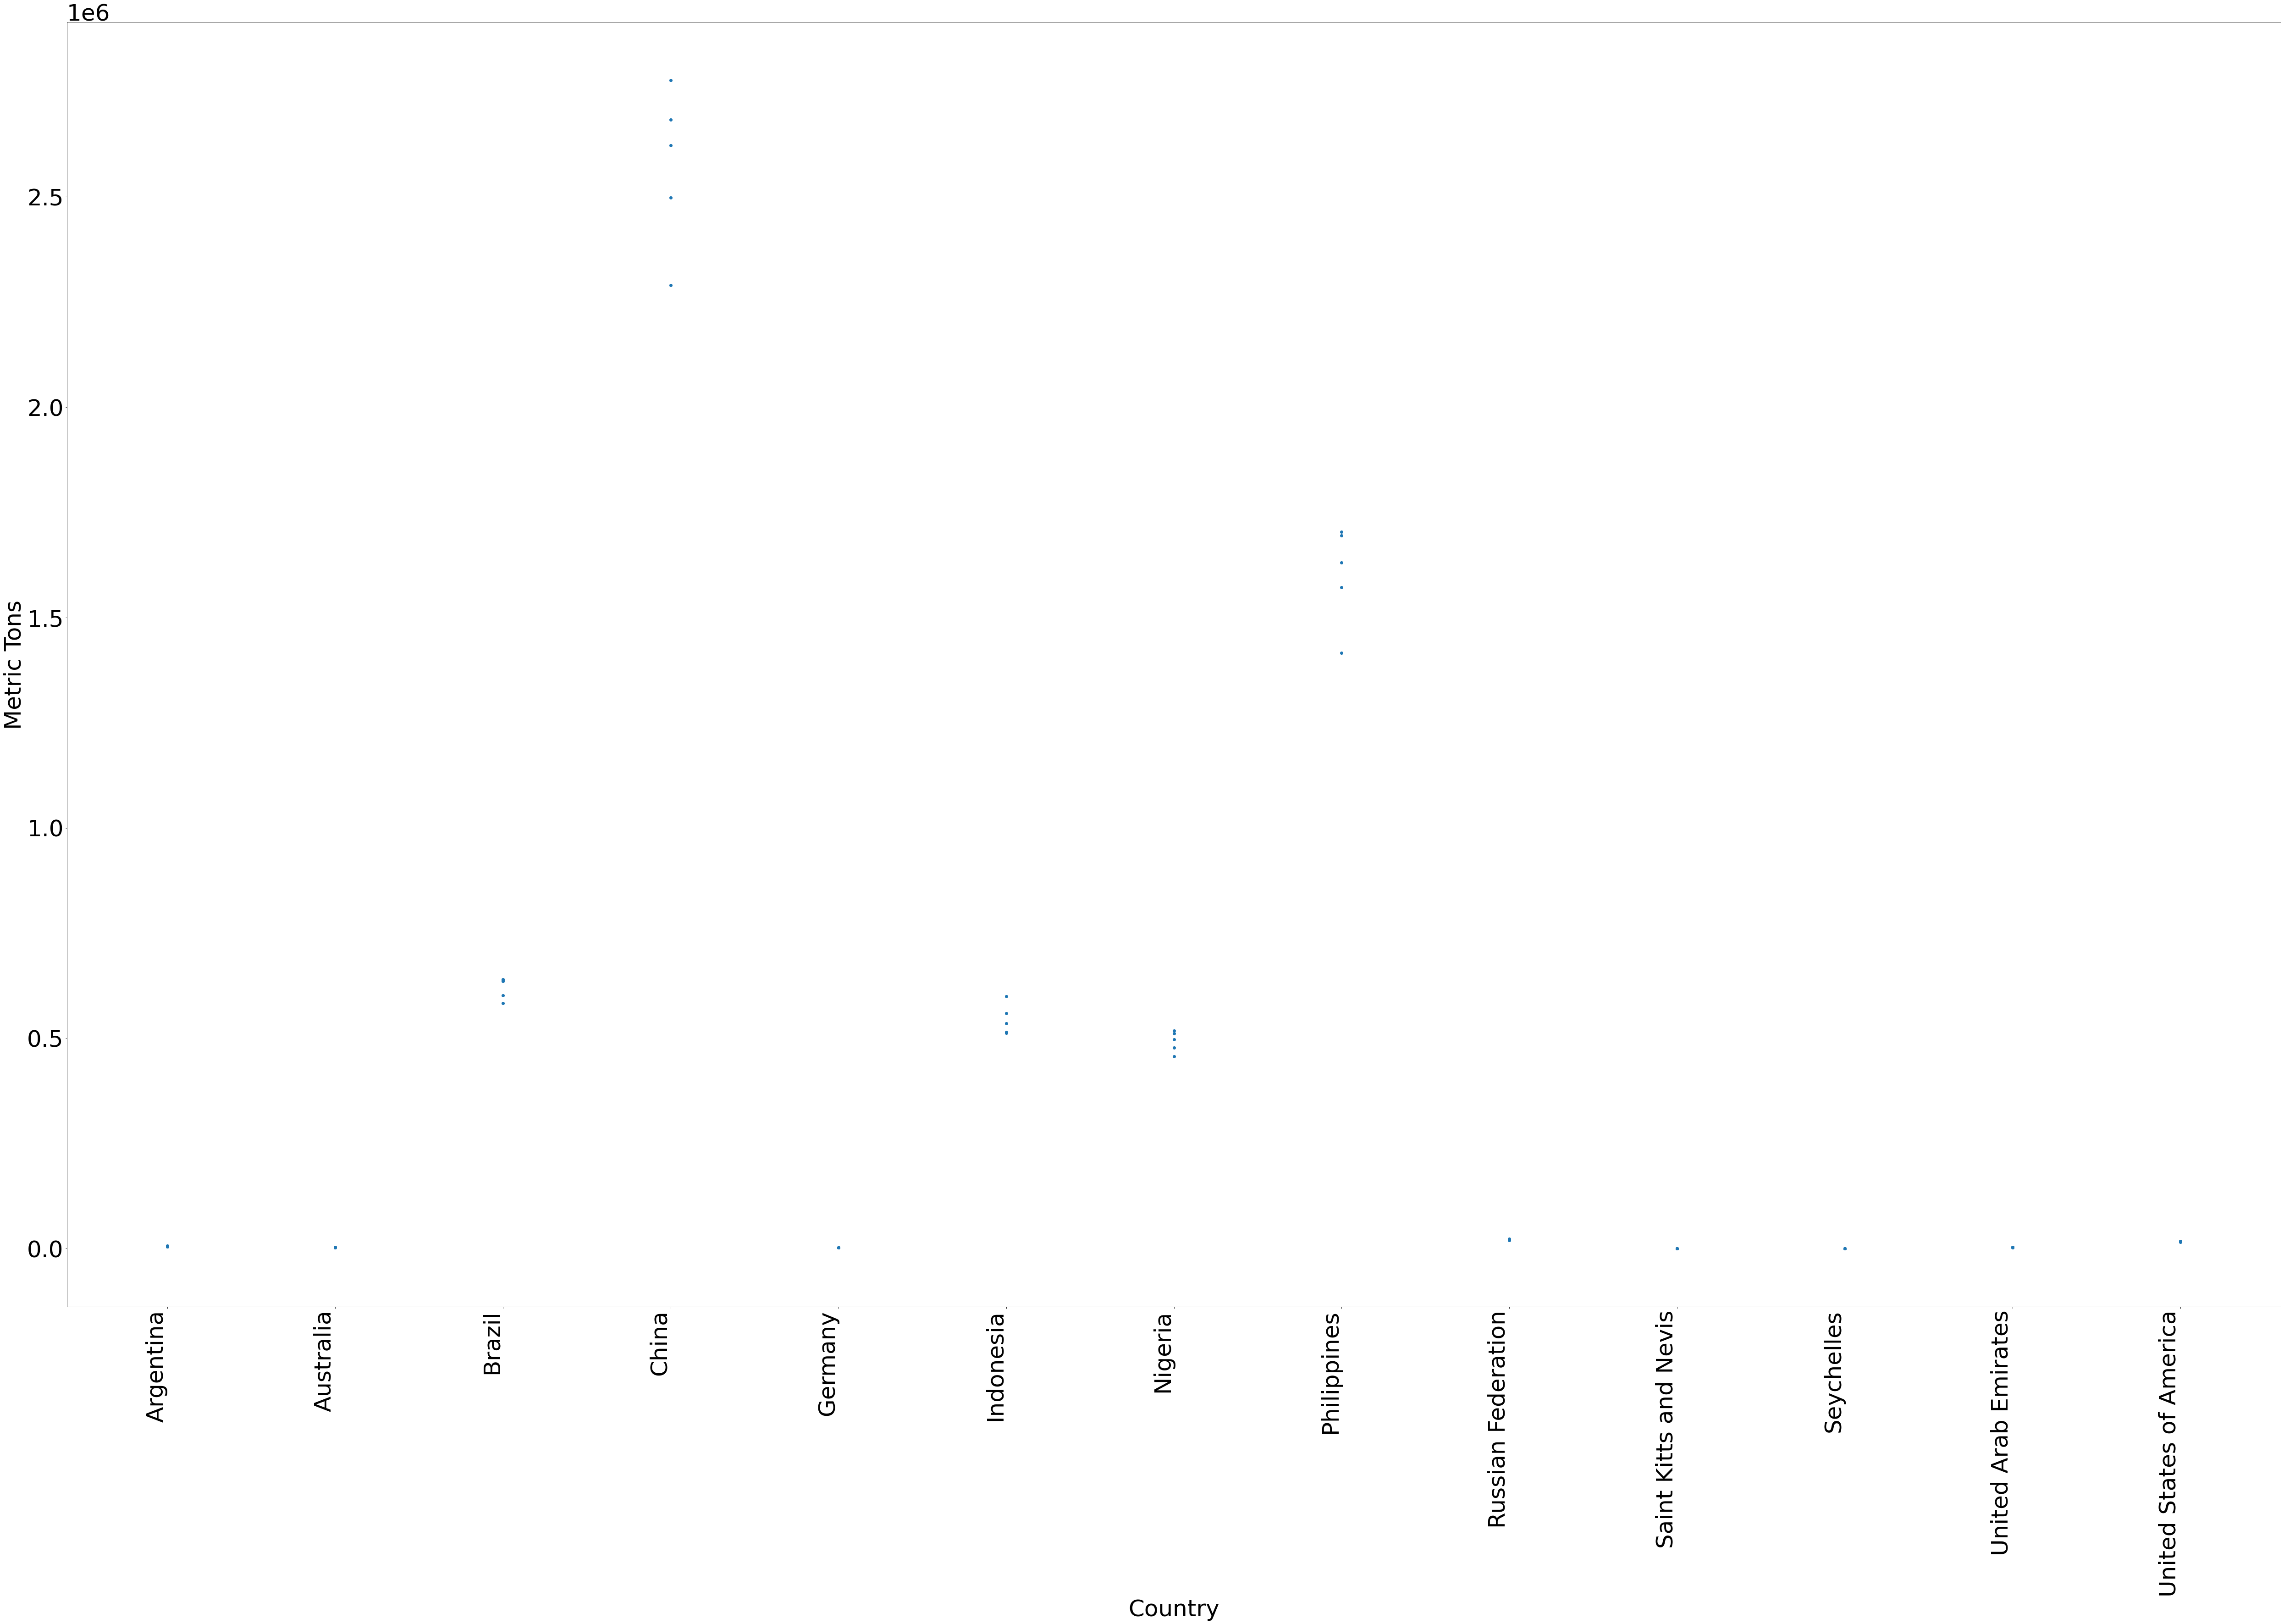

In [59]:
#Bar Graph for PBT
plt.scatter(pbt_countries_df.Country, pbt_countries_df.Metric_Tons)
plt.xlabel('Country')
plt.ylabel('Metric Tons')
plt.xticks(rotation=90, ha='right')
# plt.rcParams["figure.figsize"] = [70.50, 50.50]
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["font.size"] = "50"
plt.show()

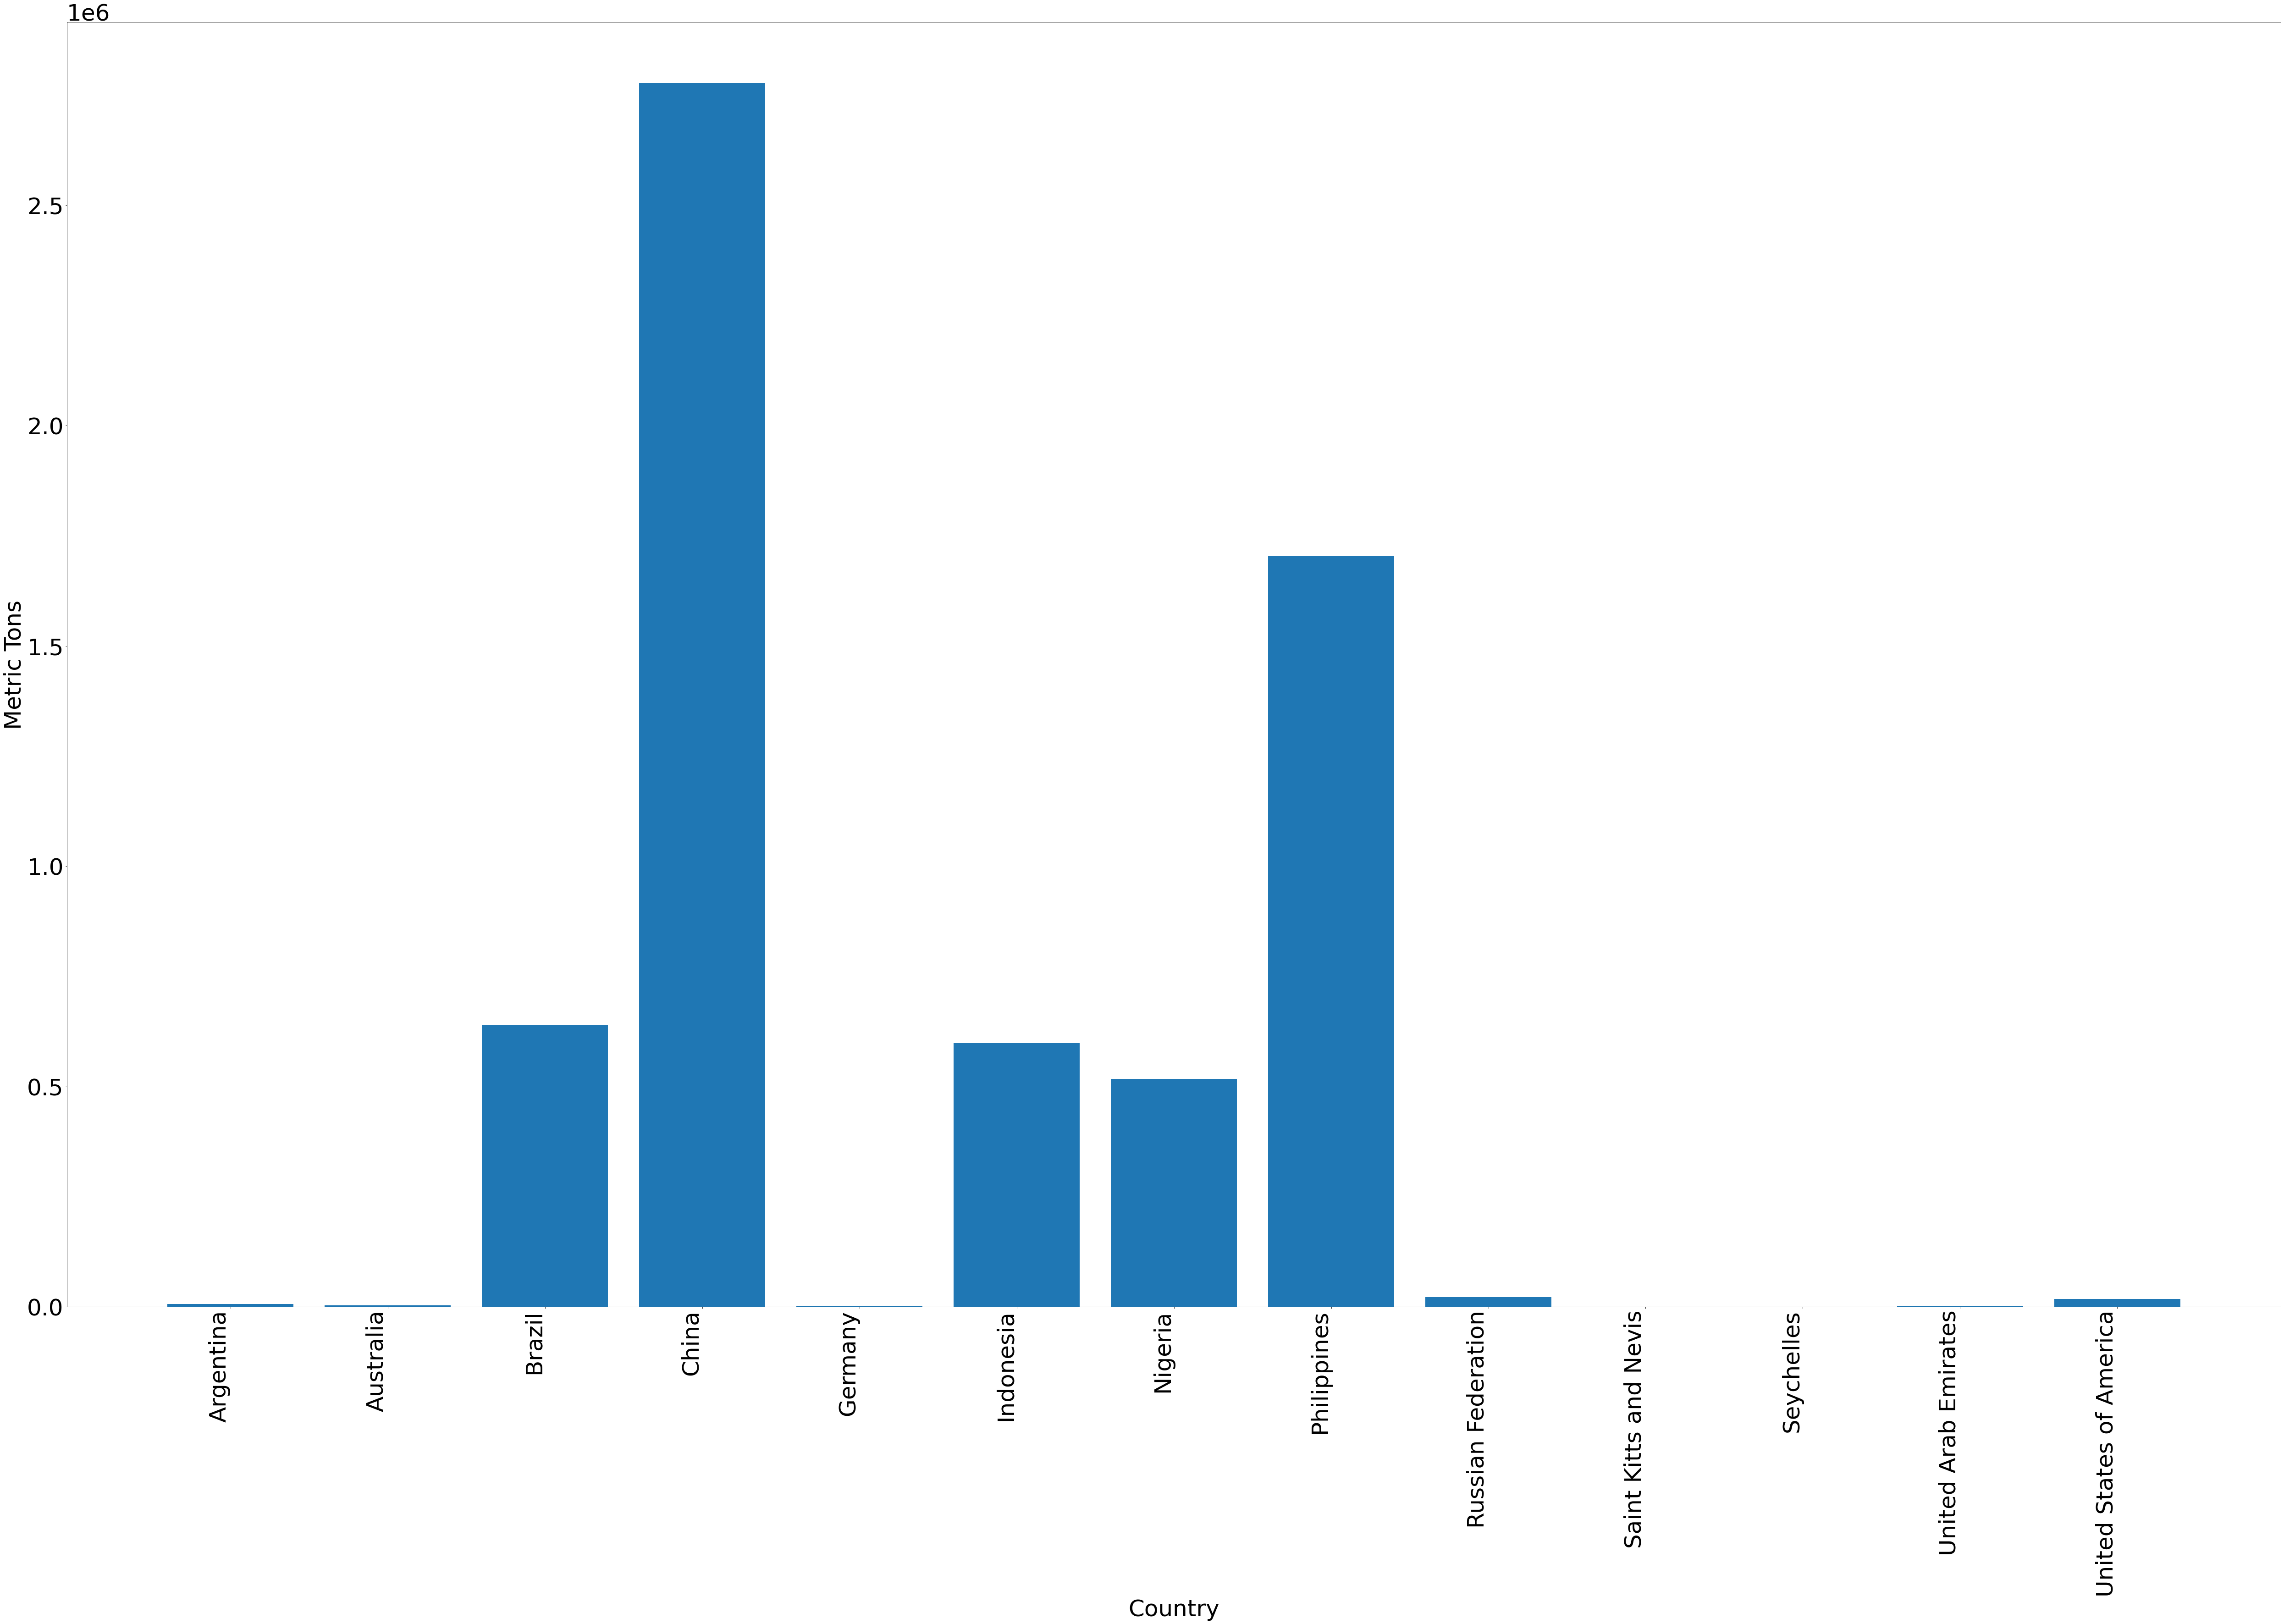

In [52]:
#Bar Graph for PBT
plt.bar(pbt_countries_df.Country, pbt_countries_df.Metric_Tons)
plt.xlabel('Country')
plt.ylabel('Metric Tons')
plt.xticks(rotation=90, ha='right')
# plt.rcParams["figure.figsize"] = [70.50, 50.50]
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["font.size"] = "50"
plt.show()

In [64]:
# Merge all relevant dataframes for years 2017-2020

countries_GDP_MT = pd.merge(list_countries_df, pbt_countries_df, on=['Country', 'Year'], how='inner')
countries_GDP_MT

,Country,Year,GDP_per_capita,Population,Metric_Tons
0,Argentina,2017,23597.117188,4.393714e+07,4135.0
1,Argentina,2018,22747.242188,4.436115e+07,4473.0
2,Argentina,2019,22066.101562,4.478068e+07,4847.0
3,Argentina,2020,19690.662109,4.519578e+07,5804.0
4,Australia,2017,48398.550781,2.458462e+07,2522.0
5,Australia,2018,49029.105469,2.489815e+07,2498.0
6,Australia,2019,49309.113281,2.520320e+07,2920.0
7,Australia,2020,48678.683594,2.549988e+07,2857.0
8,Brazil,2017,14524.613281,2.078338e+08,583089.0
9,Brazil,2018,14668.255859,2.094693e+08,602121.0


In [65]:
global_total_df = pd.read_csv(r"C:\Users\mommy\Repositories\Dev\Analysis Projects\Ocean_Plastic_Pollution\Resources\Raw_Data\mismanaged-waste-global-total.csv")
global_total_df

,Entity,Code,Year,Mismanaged waste (% global total)
0,Albania,ALB,2010,0.0933
1,Algeria,DZA,2010,1.6347
2,Angola,AGO,2010,0.1964
3,Anguilla,AIA,2010,0.0002
4,Antigua and Barbuda,ATG,2010,0.0039
...,...,...,...,...
181,Uruguay,URY,2010,0.0677
182,Vanuatu,VUT,2010,0.0706
183,Venezuela,VEN,2010,0.3214
184,Vietnam,VNM,2010,5.7588


In [68]:
countries_GDP_MT.to_csv("Resources\Raw_Data\countries_GDP_MT.csv")